## Libraries and U-net arch

In [2]:
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch
import torch.nn as nn 
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
import copy
import cv2


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

## Prediction 

In [3]:
def prediction(image_pth, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.ToTensor()])

    img = transform(Image.open(image_pth)).float().to(device)
    img = img.unsqueeze(0)

    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0] = 0
    pred_mask[pred_mask > 0] = 1
    # plt.imshow(img,cmap="gray")
    return img, pred_mask


[]


True

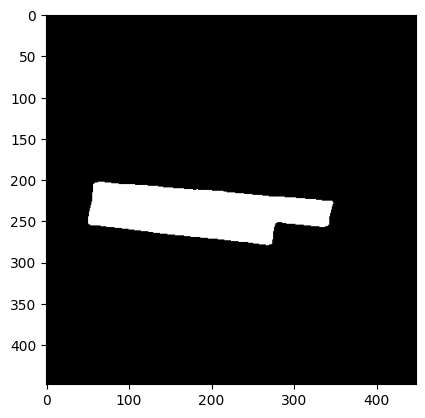

In [20]:
import os


device = "cuda" if torch.cuda.is_available() else "cpu"

data_img_path = "/home/aous/Desktop/MIPT/project/full data resized/predict/input resized 2/"
output_img_path = "/home/aous/Desktop/MIPT/project/"
img = '53.png'

input_img_path= data_img_path+img
input_image = cv2.imread(input_img_path,cv2.IMREAD_UNCHANGED)
    
model_path = "/home/aous/Desktop/MIPT/project/models/model_full_data.pth"

input_img, predicted_mask = prediction(input_img_path,model_path,device)
predicted_mask = predicted_mask.squeeze()
predicted_mask = predicted_mask.numpy().astype("uint8")
predicted_mask[predicted_mask >= 1] = 255
print(predicted_mask[predicted_mask==1])
# input_img = input_img.squeeze()
# input_img = input_img.numpy().astype("uint8")
plt.imshow(predicted_mask, cmap="gray")

cv2.imwrite(output_img_path+img, predicted_mask)

[[[195.          1.6580628]]]


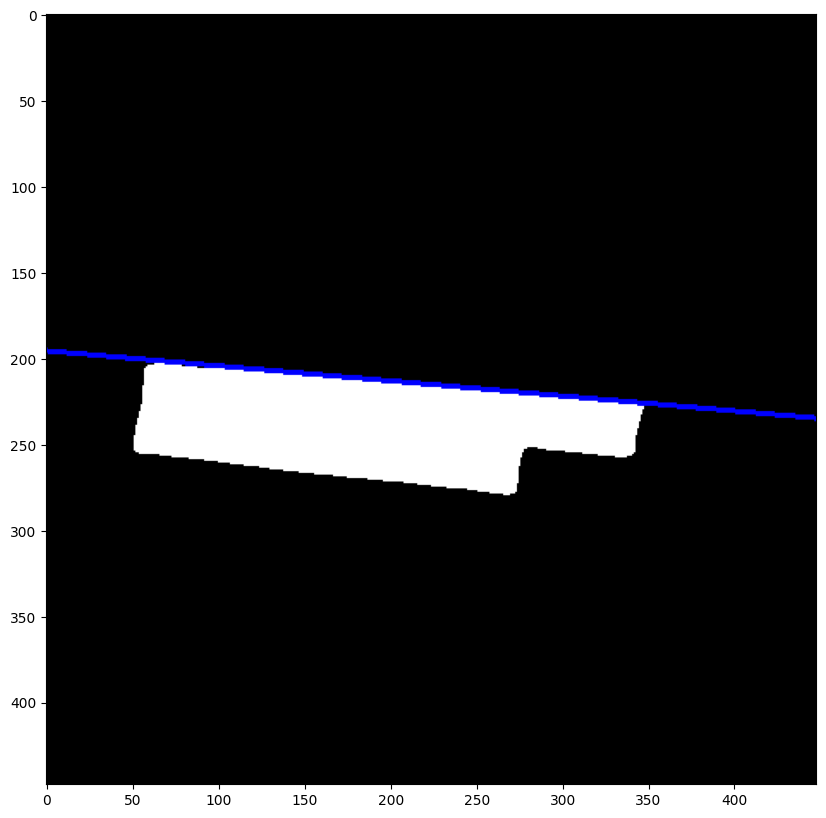

In [39]:
path = "/home/aous/Desktop/MIPT/project/53.png"
# path = "/home/aous/Desktop/MIPT/project/data 3/test/image/1285.png"
msk = cv2.imread(path)

gray = cv2.cvtColor(msk,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,128)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(msk,(x1,y1),(x2,y2),(0,0,255),2)
plt.figure(figsize=(12,10))
# plt.imshow(msk,cmap="gray")
# plt.show()


plt.imshow(msk,cmap="gray")
print(lines)

[[[100 205 346 226]]

 [[ 99 260 264 278]]]


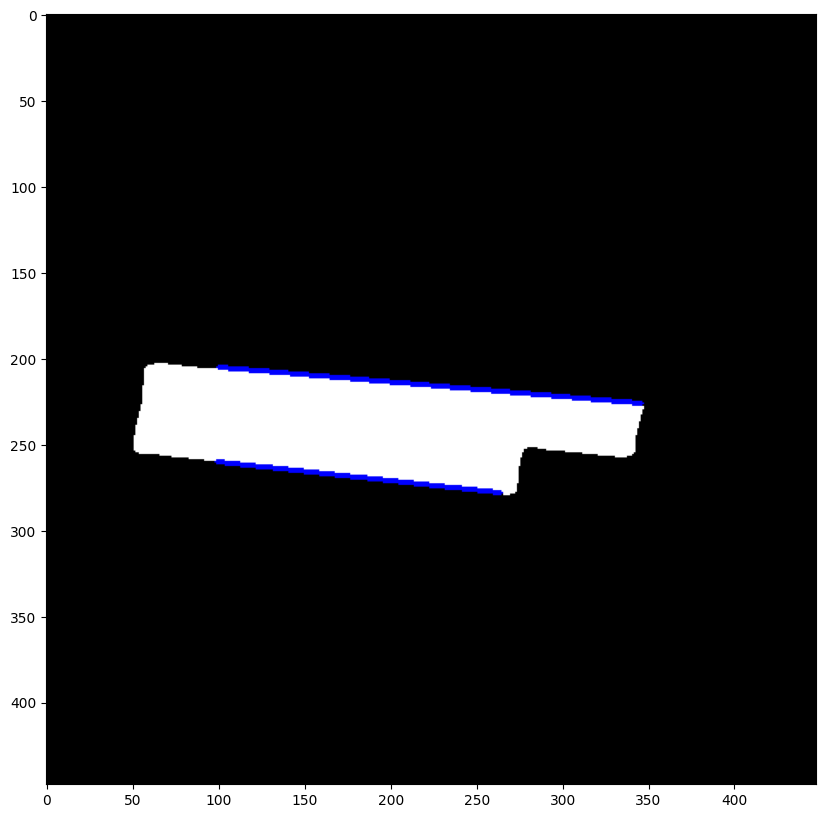

In [37]:
path = "/home/aous/Desktop/MIPT/project/53.png"
# path = "/home/aous/Desktop/MIPT/project/data 3/test/image/1285.png"
msk = cv2.imread(path)

gray = cv2.cvtColor(msk,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
# lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=20, minLineLength=50, maxLineGap=5)  # Adjust the parameters as needed
lines = cv2.HoughLinesP(edges,rho = 1,theta = 1*np.pi/180,threshold = 100,minLineLength = 20,maxLineGap = 20)

# Iterate over the detected line segments and draw them on the original image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(msk,(x1,y1),(x2,y2),(0,0,255),2)
plt.figure(figsize=(12,10))
# plt.imshow(msk,cmap="gray")
# plt.show()


plt.imshow(msk,cmap="gray")
print(lines)

array([[ 63, 203],
       [ 62, 204],
       [ 59, 204],
       [ 57, 206],
       [ 57, 215],
       [ 56, 216],
       [ 56, 226],
       [ 55, 227],
       [ 55, 230],
       [ 54, 231],
       [ 54, 234],
       [ 53, 235],
       [ 53, 238],
       [ 52, 239],
       [ 52, 244],
       [ 51, 245],
       [ 51, 253],
       [ 52, 254],
       [ 53, 254],
       [ 54, 255],
       [ 65, 255],
       [ 66, 256],
       [ 72, 256],
       [ 73, 257],
       [ 82, 257],
       [ 83, 258],
       [ 91, 258],
       [ 92, 259],
       [ 99, 259],
       [100, 260],
       [106, 260],
       [107, 261],
       [114, 261],
       [115, 262],
       [123, 262],
       [124, 263],
       [129, 263],
       [130, 264],
       [137, 264],
       [138, 265],
       [146, 265],
       [147, 266],
       [155, 266],
       [156, 267],
       [166, 267],
       [167, 268],
       [174, 268],
       [175, 269],
       [186, 269],
       [187, 270],
       [195, 270],
       [196, 271],
       [207,

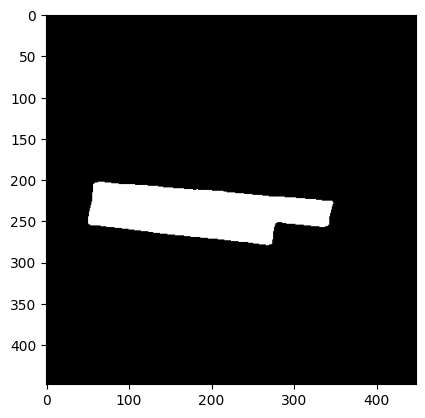

In [60]:
path = "/home/aous/Desktop/MIPT/project/53.png"
# path = "/home/aous/Desktop/MIPT/project/data 3/test/image/1285.png"
msk = cv2.imread(path)
gray = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(gray, cmap="gray")
# cv2.drawContours(msk, contours, -1, (0,255,0), 3)
contours = np.squeeze(contours)
contours

In [ ]:
I have this array, i want to find the 6 lines that fits those points and print their equations 


array([[ 63, 203],
       [ 62, 204],
       [ 59, 204],
       [ 57, 206],
       [ 57, 215],
       [ 56, 216],
       [ 56, 226],
       [ 55, 227],
       [ 55, 230],
       [ 54, 231],
       [ 54, 234],
       [ 53, 235],
       [ 53, 238],
       [ 52, 239],
       [ 52, 244],
       [ 51, 245],
       [ 51, 253],
       [ 52, 254],
       [ 53, 254],
       [ 54, 255],
       [ 65, 255],
       [ 66, 256],
       [ 72, 256],
       [ 73, 257],
       [ 82, 257],
       [ 83, 258],
       [ 91, 258],
       [ 92, 259],
       [ 99, 259],
       [100, 260],
       [106, 260],
       [107, 261],
       [114, 261],
       [115, 262],
       [123, 262],
       [124, 263],
       [129, 263],
       [130, 264],
       [137, 264],
       [138, 265],
       [146, 265],
       [147, 266],
       [155, 266],
       [156, 267],
       [166, 267],
       [167, 268],
       [174, 268],
       [175, 269],
       [186, 269],
       [187, 270],
       [195, 270],
       [196, 271],
       [207, 271],
       [208, 272],
       [215, 272],
       [216, 273],
       [223, 273],
       [224, 274],
       [232, 274],
       [233, 275],
       [244, 275],
       [245, 276],
       [250, 276],
       [251, 277],
       [257, 277],
       [258, 278],
       [265, 278],
       [266, 279],
       [269, 279],
       [270, 278],
       [272, 278],
       [273, 277],
       [273, 273],
       [274, 272],
       [274, 263],
       [275, 262],
       [275, 258],
       [276, 257],
       [276, 255],
       [277, 254],
       [277, 253],
       [278, 252],
       [279, 252],
       [280, 251],
       [285, 251],
       [286, 252],
       [290, 252],
       [291, 253],
       [301, 253],
       [302, 254],
       [311, 254],
       [312, 255],
       [320, 255],
       [321, 256],
       [330, 256],
       [331, 257],
       [337, 257],
       [338, 256],
       [340, 256],
       [342, 254],
       [342, 245],
       [343, 244],
       [343, 241],
       [344, 240],
       [344, 237],
       [345, 236],
       [345, 233],
       [346, 232],
       [346, 230],
       [347, 229],
       [347, 228],
       [346, 227],
       [346, 226],
       [334, 226],
       [333, 225],
       [327, 225],
       [326, 224],
       [314, 224],
       [313, 223],
       [303, 223],
       [302, 222],
       [289, 222],
       [288, 221],
       [270, 221],
       [269, 220],
       [262, 220],
       [261, 219],
       [250, 219],
       [249, 218],
       [240, 218],
       [239, 217],
       [229, 217],
       [228, 216],
       [219, 216],
       [218, 215],
       [215, 215],
       [214, 214],
       [201, 214],
       [200, 213],
       [184, 213],
       [183, 212],
       [182, 212],
       [181, 213],
       [178, 213],
       [177, 212],
       [167, 212],
       [166, 211],
       [154, 211],
       [153, 210],
       [142, 210],
       [141, 209],
       [136, 209],
       [135, 208],
       [123, 208],
       [122, 207],
       [108, 207],
       [107, 206],
       [ 88, 206],
       [ 87, 205],
       [ 79, 205],
       [ 78, 204],
       [ 71, 204],
       [ 70, 203]], dtype=int32)

In [74]:
from sklearn.linear_model import RANSACRegressor

# Given points
points = contours
# print(points)
# Convert points to numpy array


# Fit lines using RANSAC

num_lines = 6
lines = []

for _ in range(num_lines):
    model = RANSACRegressor()
    model.fit(points[:, 0].reshape(-1, 1), points[:, 1])
    
    # Get the fitted line
    slope = model.estimator_.coef_[0]
    intercept = model.estimator_.intercept_
    
    # Store the line equation
    lines.append((slope, intercept))
    
    # Remove inliers of the fitted line
    inliers = model.inlier_mask_
    points = points[~inliers]

# Print the equations of the lines
for i, line in enumerate(lines):
    slope, intercept = line
    equation = f"Line {i+1}: y = {slope:.2f}x + {intercept:.2f}"
    print(equation)

ValueError: `min_samples` may not be larger than number of samples: n_samples = 1.

TypeError: Image data of dtype object cannot be converted to float

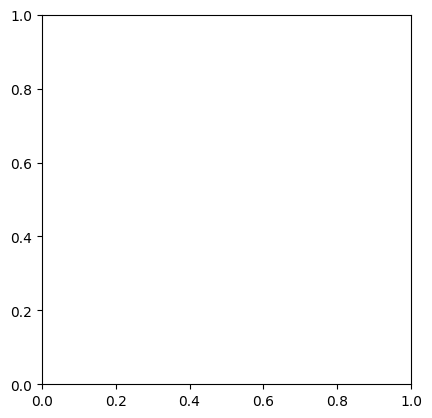

In [79]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Given vertices
vertices = [[0, 0], [1, 1], [2, 0], [1, -1]]  # Example vertices

# Extract x and y coordinates from vertices
x = [vertex[0] for vertex in vertices]
y = [vertex[1] for vertex in vertices]

# Create a Polygon patch
polygon = Polygon(vertices, closed=True)

# Create a figure and axis
plt.imshow(polygon)

# Show the plot
plt.show()

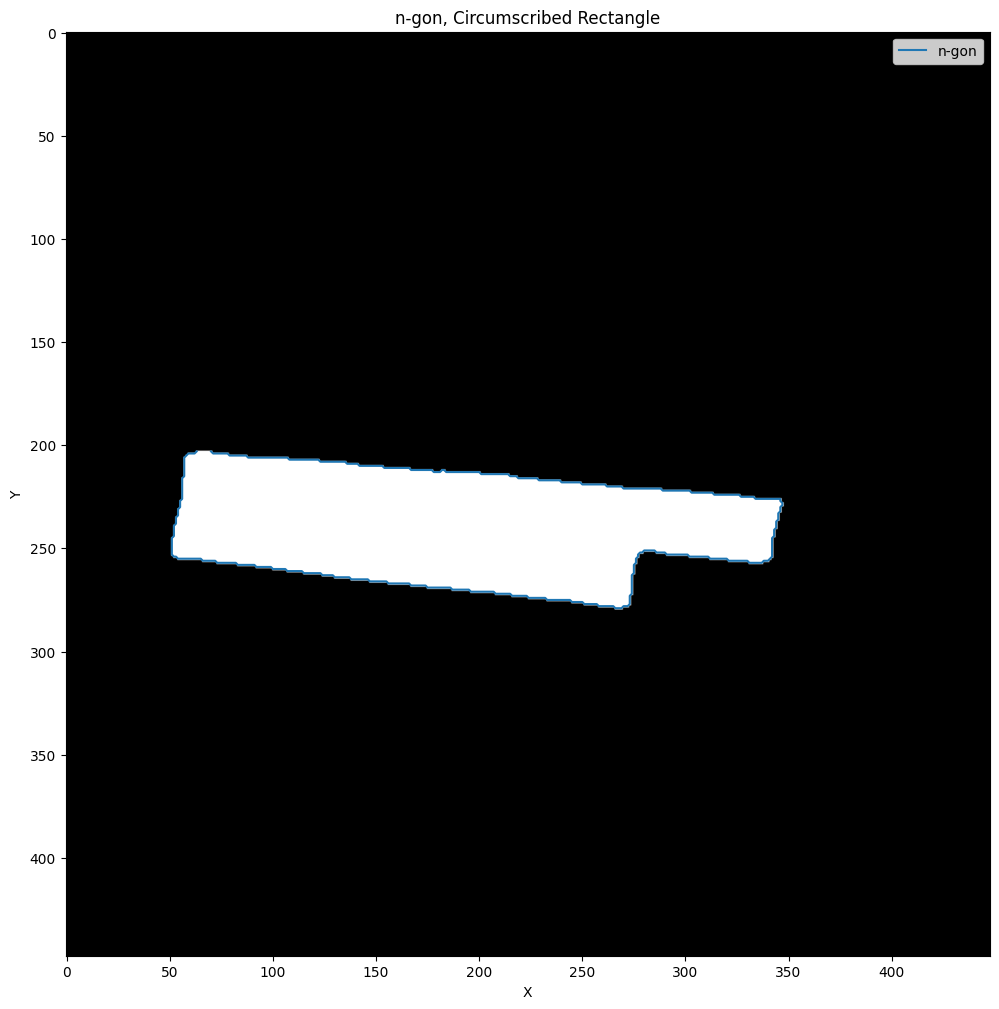

In [95]:
def construct_circumscribed_rectangle(vertices):
    min_x = np.min(vertices[:, 0])
    max_x = np.max(vertices[:, 0])
    min_y = np.min(vertices[:, 1])
    max_y = np.max(vertices[:, 1])

    rect_vertices = np.array([
        [min_x, min_y],
        [max_x, min_y],
        [max_x, max_y],
        [min_x, max_y],
        [min_x, min_y]
    ])

    return rect_vertices
x = [vertex[0] for vertex in contours]
y = [vertex[1] for vertex in contours]
# new input polygon
# x = [1.5, 1.4, 2.5, 2, 1, 0, -0.5, -0.25, 0.6, 1.5]
# y =  [-0.4, 1, 1.5, 2.5, 3.2, 2.5, 1.5, 0.5, -0.5,-0.4]

# discretized polygon from step 1 with n = 1000
# x = discretized_polygon_2[0].tolist()
# y = discretized_polygon_2[1].tolist()

polygon_vertices = np.array(list(zip(x, y)))
    # Given 4-gon vertices
# fourgon_vertices = np.array([
#         [2, 3],
#         [4, 5],
#         [6, 7],
#         [8, 9]
#     ])

    # Construct the circumscribed rectangle
# rect_vertices = construct_circumscribed_rectangle(polygon_vertices)
plt.figure(figsize=(14,12))
plt.imshow(msk)
plt.plot(polygon_vertices[:, 0], polygon_vertices[:, 1], label='n-gon')
# plt.plot(rect_vertices[:, 0], rect_vertices[:, 1], label='Circumscribed Rectangle')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('n-gon, Circumscribed Rectangle')
plt.legend()
plt.show()

In [92]:
# contours = contours.tolist()
contours

[[63, 203],
 [62, 204],
 [59, 204],
 [57, 206],
 [57, 215],
 [56, 216],
 [56, 226],
 [55, 227],
 [55, 230],
 [54, 231],
 [54, 234],
 [53, 235],
 [53, 238],
 [52, 239],
 [52, 244],
 [51, 245],
 [51, 253],
 [52, 254],
 [53, 254],
 [54, 255],
 [65, 255],
 [66, 256],
 [72, 256],
 [73, 257],
 [82, 257],
 [83, 258],
 [91, 258],
 [92, 259],
 [99, 259],
 [100, 260],
 [106, 260],
 [107, 261],
 [114, 261],
 [115, 262],
 [123, 262],
 [124, 263],
 [129, 263],
 [130, 264],
 [137, 264],
 [138, 265],
 [146, 265],
 [147, 266],
 [155, 266],
 [156, 267],
 [166, 267],
 [167, 268],
 [174, 268],
 [175, 269],
 [186, 269],
 [187, 270],
 [195, 270],
 [196, 271],
 [207, 271],
 [208, 272],
 [215, 272],
 [216, 273],
 [223, 273],
 [224, 274],
 [232, 274],
 [233, 275],
 [244, 275],
 [245, 276],
 [250, 276],
 [251, 277],
 [257, 277],
 [258, 278],
 [265, 278],
 [266, 279],
 [269, 279],
 [270, 278],
 [272, 278],
 [273, 277],
 [273, 273],
 [274, 272],
 [274, 263],
 [275, 262],
 [275, 258],
 [276, 257],
 [276, 255],
 [

In [90]:
x

[[63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63, 203],
 [63